In [1]:
import numpy as np
import os, requests, cv2, random
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [22]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    horizontal_flip=True,
    vertical_flip=True,
)

valid_datagen = ImageDataGenerator(    
    rescale=1./255,
    rotation_range=45,
    horizontal_flip=True,
    vertical_flip=True,
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    horizontal_flip=True,
    vertical_flip=True,
)

training_dir = r'D:\DATASET\Line_Model\PTI\train_dataset'
validation_dir = r'D:\DATASET\Line_Model\PTI\val_dataset'
testing_dir = r'D:\DATASET\Line_Model\PTI\test_dataset'

In [23]:
# Load the training dataset using the ImageDataGenerator
train_dataset = train_datagen.flow_from_directory(
    training_dir,
    target_size=(256, 256),
    batch_size=10,
    class_mode='binary',
    shuffle=False
)


# Load the validation dataset using the ImageDataGenerator
validation_dataset = valid_datagen.flow_from_directory(
    validation_dir,
    target_size=(256, 256),  
    batch_size=10,
    class_mode='binary',
    shuffle=False
)

# Load the validation dataset using the ImageDataGenerator
testing_dataset = valid_datagen.flow_from_directory(
    testing_dir,
    target_size=(256, 256),  
    batch_size=10,
    class_mode='binary',
    shuffle=False
)

Found 2800 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [5]:
# Print the number of classes in the dataset
num_classes = len(train_dataset.class_indices)
print("Number of classes:", num_classes)

# Print the names of the classes
class_names = list(train_dataset.class_indices.keys())
print("Class names:", class_names)

# Print the number of training and validation images
print("Number of training images:", train_dataset.n)
print("Number of validation images:", validation_dataset.n)

Number of classes: 2
Class names: ['abnormal', 'normal']
Number of training images: 2800
Number of validation images: 400


In [6]:



model = Sequential()

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=[256, 256, 3]))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5)) 
model.add(layers.Dense(1, activation='sigmoid'))


In [7]:
# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(
    optimizer=opt,
    loss='binary_crossentropy', 
    metrics=['accuracy'],
    run_eagerly=None
)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 batch_normalization_1 (Batc  (None, 125, 125, 128)    512       
 hNormalization)                                                 
                                                        

In [8]:
# Define the checkpoint callback to save the model with the minimum loss
checkpoint_callback = ModelCheckpoint('PTI_model.h5', 
                                      monitor='val_loss', 
                                      mode="min",
                                      save_best_only=True)

In [9]:
# Define early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  
    patience=2,          
    verbose=1,            
    restore_best_weights=True  
)

In [10]:
# Train the model with the checkpoint callback
history = model.fit(train_dataset,
                    batch_size=10,
                    epochs=100, 
                    validation_data=validation_dataset, 
                    callbacks=[checkpoint_callback,early_stopping_callback])

Epoch 1/100
280/280 [==============================] - 199s 674ms/step - loss: 274.4935 - accuracy: 0.8836 - val_loss: 3.2751 - val_accuracy: 0.7225
Epoch 2/100
280/280 [==============================] - 195s 695ms/step - loss: 0.2441 - accuracy: 0.9032 - val_loss: 0.0817 - val_accuracy: 0.9075
Epoch 3/100
280/280 [==============================] - 205s 732ms/step - loss: 0.2486 - accuracy: 0.8950 - val_loss: 0.1251 - val_accuracy: 0.8950
Epoch 4/100
280/280 [==============================] - 207s 739ms/step - loss: 0.2294 - accuracy: 0.9075 - val_loss: 0.3009 - val_accuracy: 0.7725
Epoch 4: early stopping


In [11]:
# Evaluate the model on the train dataset

model = tf.keras.models.load_model(r'PTI_model.h5')
loss, accuracy = model.evaluate(train_dataset)
print('Train Accuracy: {:.2f}%'.format(accuracy*100))
print('Train Loss: {:.2f}'.format(loss))

280/280 [==============================] - 67s 237ms/step - loss: 0.0566 - accuracy: 0.9561
Train Accuracy: 95.61%
Train Loss: 0.06


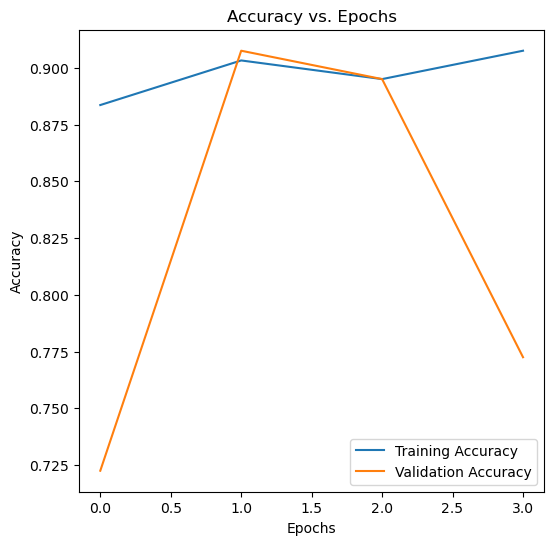

In [12]:
# Plot accuracy vs. epochs
plt.figure(figsize=(6, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.savefig('accuracy_vs_epochs.png') 

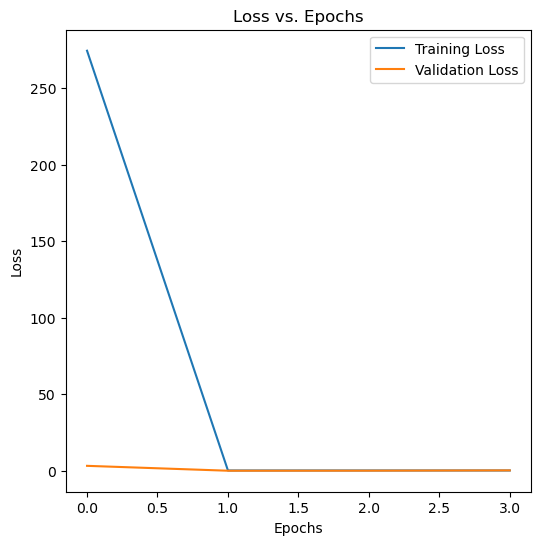

In [13]:
# Plot loss vs. epochs
plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.savefig('loss_vs_epochs.png')  
plt.show()

In [24]:
# Load the saved model
model = tf.keras.models.load_model(r'PTI_model.h5')

# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(testing_dataset)
print('Test Accuracy: {:.2f}%'.format(accuracy*100))
print('Test Loss: {:.2f}'.format(loss))


80/80 [==============================] - 20s 244ms/step - loss: 63.5187 - accuracy: 0.8675
Test Accuracy: 86.75%
Test Loss: 63.52
